In [1]:
import os

# TensorFlow is the only backend that supports string inputs.
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import pandas as pd
import keras
from keras import layers

In [2]:

dataframe = pd.read_csv('/content/training_with_labels.csv')

In [3]:
dataframe.shape

(164, 7)

In [ ]:
dataframe=dataframe.drop("TIME", axis='columns')


In [4]:
dataframe

,amplitude,duration,energy,rms,rise_time,counts,label
0,0.000052,1.577000e-03,37.843311,0.000016,2.489000e-04,12,0
1,0.000044,1.068700e-03,23.700146,0.000015,4.792000e-04,5,0
2,0.000033,1.000000e-07,3.083569,0.000555,1.000000e-07,0,0
3,0.000070,3.074100e-03,66.439868,0.000015,7.246000e-04,26,0
4,0.000033,1.000000e-07,3.036816,0.000551,1.000000e-07,0,0
...,...,...,...,...,...,...,...
159,0.000083,2.287100e-03,101.903882,0.000021,3.891000e-04,57,1
160,0.000086,2.890400e-03,138.352051,0.000022,2.514000e-04,69,1
161,0.000111,2.692500e-03,179.075415,0.000026,4.853000e-04,78,1
162,0.000198,4.503600e-03,773.948999,0.000041,1.036800e-03,149,1


In [5]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    f"Using {len(train_dataframe)} samples for training "
    f"and {len(val_dataframe)} for validation"
)

Using 131 samples for training and 33 for validation


In [7]:

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [8]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=0.000239063>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.0046028>, 'energy': <tf.Tensor: shape=(), dtype=float64, numpy=934.7295898>, 'rms': <tf.Tensor: shape=(), dtype=float64, numpy=4.51e-05>, 'rise_time': <tf.Tensor: shape=(), dtype=float64, numpy=0.0004858>, 'counts': <tf.Tensor: shape=(), dtype=int64, numpy=148>}
Target: tf.Tensor(1, shape=(), dtype=int64)


In [9]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [10]:

def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = layers.Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = layers.StringLookup if is_string else layers.IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [13]:
'''
# Categorical features encoded as integers
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = keras.Input(shape=(1,), name="exang", dtype="int64")
ca = keras.Input(shape=(1,), name="ca", dtype="int64")

# Categorical feature encoded as string
thal = keras.Input(shape=(1,), name="thal", dtype="string")
'''
# Numerical features
counts = keras.Input(shape=(1,), name="counts")
amplitude = keras.Input(shape=(1,), name="amplitude")
duration = keras.Input(shape=(1,), name="duration")
energy = keras.Input(shape=(1,), name="energy")
rms = keras.Input(shape=(1,), name="rms")
rise_time = keras.Input(shape=(1,), name="rise_time")

all_inputs = [
    counts,
    amplitude,
    duration,
    energy,
    rms,
    rise_time,

]
'''
# Integer categorical features
sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

# String categorical features
thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)
'''
# Numerical features
counts_encoded = encode_numerical_feature(counts, "counts", train_ds)
amplitude_encoded = encode_numerical_feature(amplitude, "amplitude", train_ds)
duration_encoded = encode_numerical_feature(duration, "duration", train_ds)
energy_encoded = encode_numerical_feature(energy, "energy", train_ds)
rms_encoded = encode_numerical_feature(rms, "rms", train_ds)
rise_time = encode_numerical_feature(rise_time, "rise_time", train_ds)

all_features = layers.concatenate(
    [
        counts_encoded,
        rms_encoded,
        amplitude_encoded,
        duration_encoded,
        energy_encoded,
        rise_time,

    ]
)
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)############# change the number of nodes= number of classes (if it binary change the actiation and the loss)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

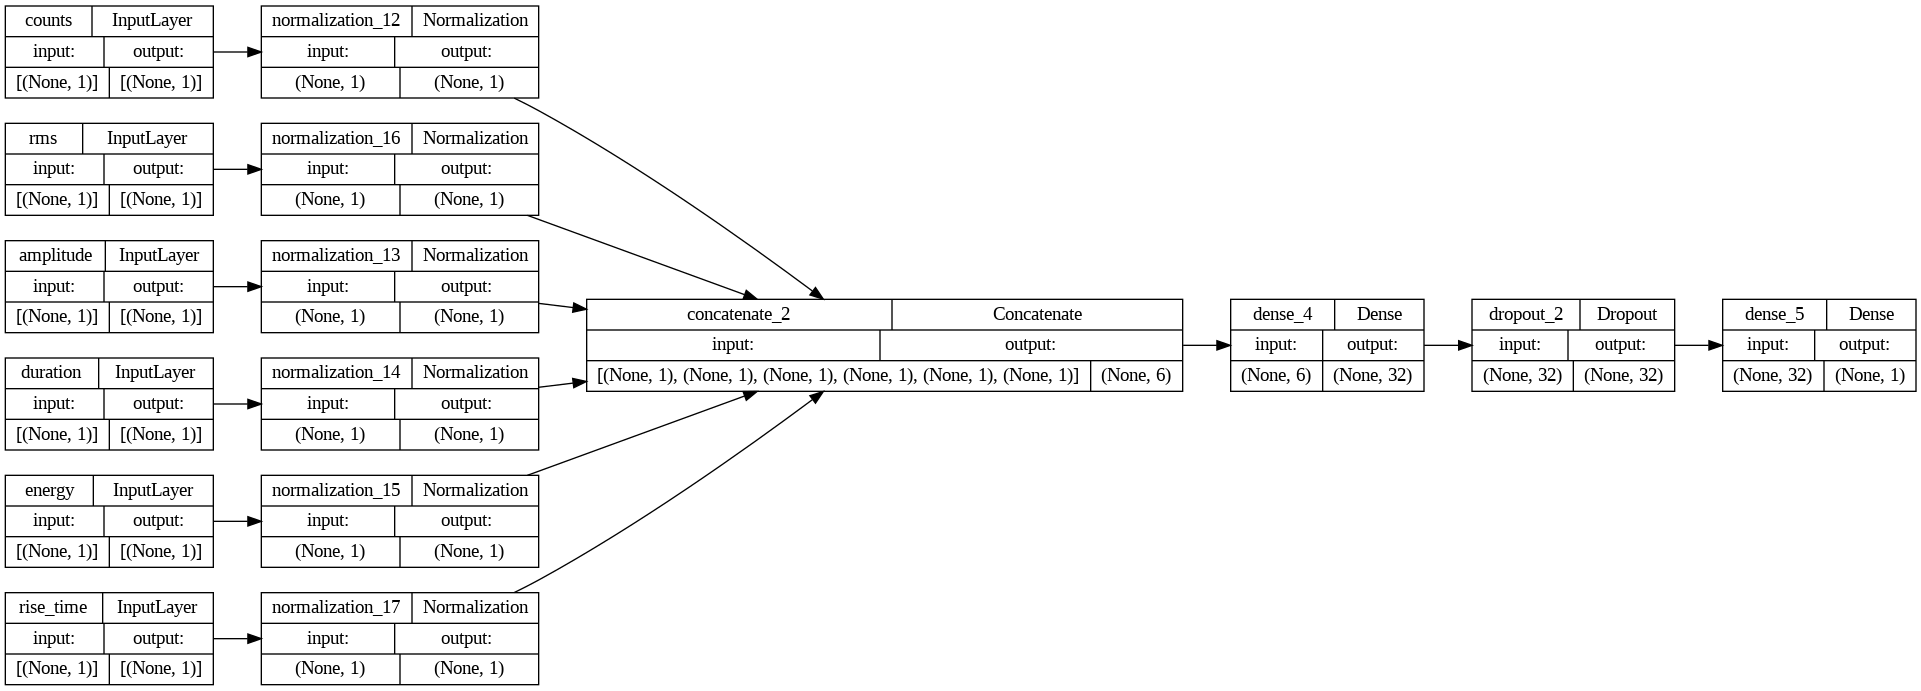

In [14]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [19]:
history =model.fit(train_ds, epochs=300, validation_data=val_ds)

Epoch 1/300
5/5 [==============================] - 0s 11ms/step - loss: 0.6177 - accuracy: 0.6412 - val_loss: 1.7552 - val_accuracy: 0.4848
Epoch 2/300
5/5 [==============================] - 0s 8ms/step - loss: 0.6318 - accuracy: 0.6565 - val_loss: 1.6974 - val_accuracy: 0.4848
Epoch 3/300
5/5 [==============================] - 0s 7ms/step - loss: 0.6220 - accuracy: 0.6336 - val_loss: 1.6699 - val_accuracy: 0.4848
Epoch 4/300
5/5 [==============================] - 0s 7ms/step - loss: 0.6843 - accuracy: 0.6412 - val_loss: 1.6584 - val_accuracy: 0.4848
Epoch 5/300
5/5 [==============================] - 0s 11ms/step - loss: 0.6079 - accuracy: 0.6641 - val_loss: 1.6574 - val_accuracy: 0.4848
Epoch 6/300
5/5 [==============================] - 0s 8ms/step - loss: 0.5831 - accuracy: 0.6947 - val_loss: 1.6713 - val_accuracy: 0.4848
Epoch 7/300
5/5 [==============================] - 0s 8ms/step - loss: 0.6057 - accuracy: 0.6947 - val_loss: 1.7083 - val_accuracy: 0.4848
Epoch 8/300
5/5 [========

In [20]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

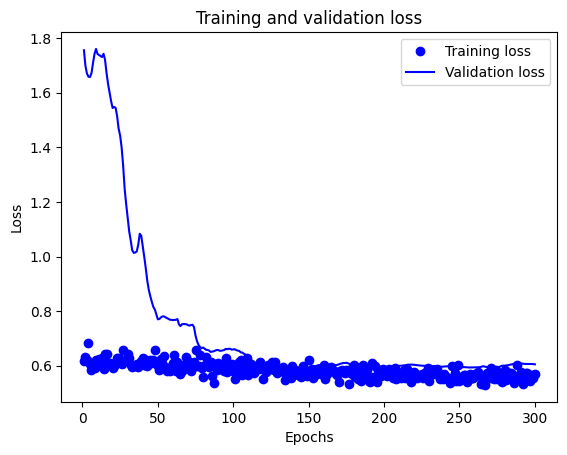

In [21]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

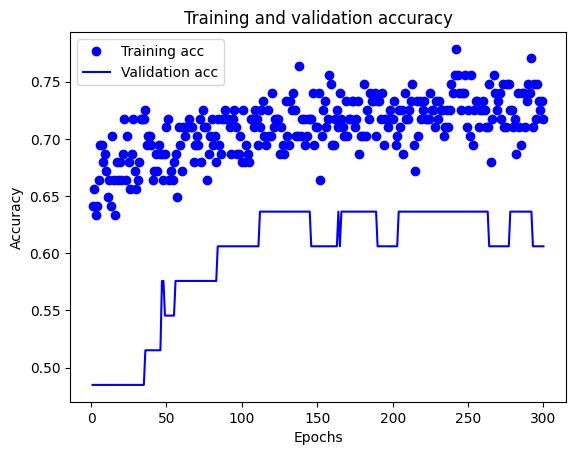

In [22]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [23]:
model.save('class_bi.h5')# sometimes .keras

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
